# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [137]:
import pandas as pd
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins.dropna(subset=['bill_depth_mm'], inplace=True)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [138]:
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

num_transform = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scalar", StandardScaler())
])
cat_transform = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("dummy", OneHotEncoder())
])

ct = ColumnTransformer([
    ('num', num_transform, make_column_selector(dtype_include=np.number)),
    ("cat", cat_transform, make_column_selector(dtype_include=object))
])

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [139]:
X = penguins.drop(columns=['species'])
y = penguins['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_knn5 = Pipeline(
    [("preprocessor", ct),
     ("kNN", KNeighborsClassifier(n_neighbors=5))]
)

pipeline_knn10 = Pipeline(
    [("preprocessor", ct),
     ("kNN", KNeighborsClassifier(n_neighbors=10))]
)

pipeline_tree1 = Pipeline(
    [("preprocessor", ct),
     ("decision", DecisionTreeClassifier(ccp_alpha=1))]
)

pipeline_tree01 = Pipeline(
    [("preprocessor", ct),
     ("decision", DecisionTreeClassifier(ccp_alpha=0.1))]
)

In [140]:
pipeline_knn5.fit(X_train, y_train)
pipeline_knn10.fit(X_train, y_train)
pipeline_tree1.fit(X_train, y_train)
pipeline_tree01.fit(X_train, y_train)

pred_knn5 = pipeline_knn5.predict(X_test)
pred_knn10 = pipeline_knn10.predict(X_test)
pred_tree1 = pipeline_tree1.predict(X_test)
pred_tree01 = pipeline_tree01.predict(X_test)

prob_knn5 = pipeline_knn5.predict_proba(X_test)
prob_knn10 = pipeline_knn10.predict_proba(X_test)
prob_tree1 = pipeline_tree1.predict_proba(X_test)
prob_tree01 = pipeline_tree01.predict_proba(X_test)

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_metrics(y_true, y_pred, prob, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

    print(classification_report(y_true, y_pred, zero_division=0))
    print(roc_auc_score(y_true, prob, multi_class='ovr'))


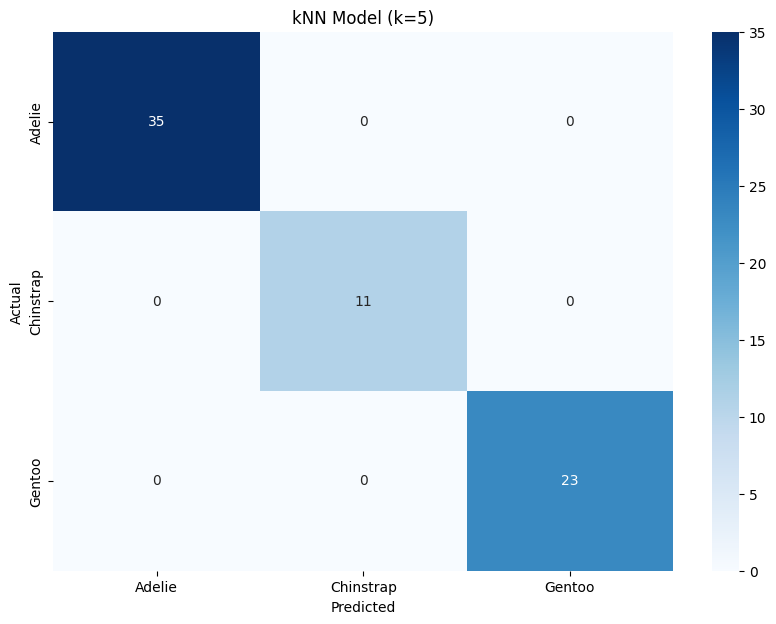

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        35
   Chinstrap       1.00      1.00      1.00        11
      Gentoo       1.00      1.00      1.00        23

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

1.0


In [142]:
model_metrics(y_test, pred_knn5, prob_knn5, 'kNN Model (k=5)')


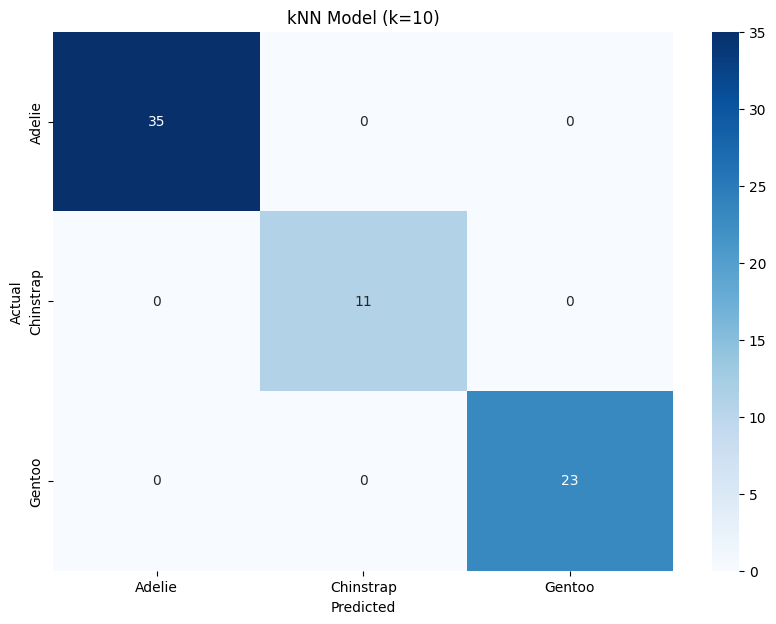

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        35
   Chinstrap       1.00      1.00      1.00        11
      Gentoo       1.00      1.00      1.00        23

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

1.0


In [143]:
model_metrics(y_test, pred_knn10, prob_knn10, 'kNN Model (k=10)')


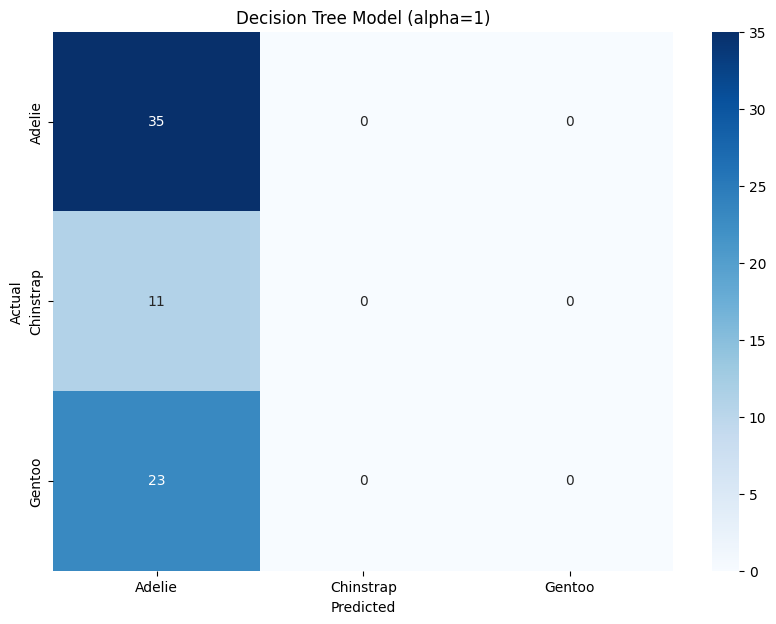

              precision    recall  f1-score   support

      Adelie       0.51      1.00      0.67        35
   Chinstrap       0.00      0.00      0.00        11
      Gentoo       0.00      0.00      0.00        23

    accuracy                           0.51        69
   macro avg       0.17      0.33      0.22        69
weighted avg       0.26      0.51      0.34        69

0.5


In [144]:
model_metrics(y_test, pred_tree1, prob_tree1, 'Decision Tree Model (alpha=1)')

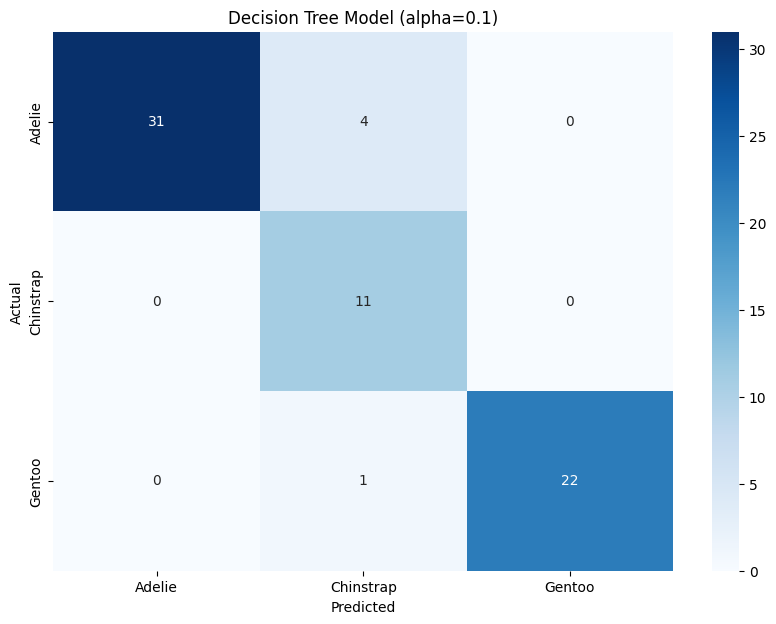

              precision    recall  f1-score   support

      Adelie       1.00      0.89      0.94        35
   Chinstrap       0.69      1.00      0.81        11
      Gentoo       1.00      0.96      0.98        23

    accuracy                           0.93        69
   macro avg       0.90      0.95      0.91        69
weighted avg       0.95      0.93      0.93        69

0.9765465458721133


In [145]:
model_metrics(y_test, pred_tree01, prob_tree01, 'Decision Tree Model (alpha=0.1)')

In [146]:
y_bin_adelie = (y_test == 'Adelie').astype(int)
 
class_names = pipeline_knn5.classes_
class_index_adelie = list(class_names).index('Adelie')

prob_adelie_knn5 = prob_knn5[:, class_index_adelie]
prob_adelie_knn10 = prob_knn10[:, class_index_adelie]
prob_adelie_tree1 = prob_tree1[:, class_index_adelie]
prob_adelie_tree01 = prob_tree01[:, class_index_adelie]

fpr_knn5, tpr_knn5, _ = roc_curve(y_bin_adelie, prob_adelie_knn5)
roc_auc_knn5 = auc(fpr_knn5, tpr_knn5)

fpr_knn10, tpr_knn10, _ = roc_curve(y_bin_adelie, prob_adelie_knn10)
roc_auc_knn10 = auc(fpr_knn10, tpr_knn10)

fpr_tree1, tpr_tree1, _ = roc_curve(y_bin_adelie, prob_adelie_tree1)
roc_auc_tree1 = auc(fpr_tree1, tpr_tree1)

fpr_tree01, tpr_tree01, _ = roc_curve(y_bin_adelie, prob_adelie_tree01)
roc_auc_tree01 = auc(fpr_tree01, tpr_tree01)

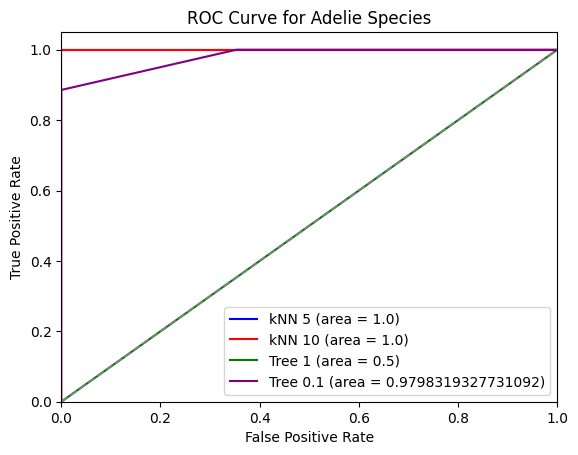

In [147]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(fpr_knn5, tpr_knn5, color='blue', label=f'kNN 5 (area = {roc_auc_knn5})')
plt.plot(fpr_knn10, tpr_knn10, color='red', label=f'kNN 10 (area = {roc_auc_knn10})')
plt.plot(fpr_tree1, tpr_tree1, color='green', label=f'Tree 1 (area = {roc_auc_tree1})')
plt.plot(fpr_tree01, tpr_tree01, color='purple', label=f'Tree 0.1 (area = {roc_auc_tree01})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Adelie Species')
plt.legend(loc="lower right")
plt.show()